In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set() 

In [3]:
final_data = pd.read_csv("final_data.csv")
final_data.drop(labels="Unnamed: 0", axis="columns", inplace=True)
final_data

FileNotFoundError: [Errno 2] No such file or directory: 'final_data.csv'



### **Problem 3: Discovering team playstyles using clustering**

Maybe there is some style of play that certain teams play in that makes certain teams more successful? Or maybe there is some combination of actions (meaning, maximising certain variables and minimising others, beyond just taking more shots) that is done in the game that is more likely to lead to a win? These are insights that we want to find out using unsupervised learning methods - so lets try a couple of clustering models to see where that takes us. 

# Model 3: K-Means Classifier


Since we want to find 'style of play', let's only take the variables that football teams are able to control, and are relevant to their playstyle

In [4]:
predictors = final_data[["HomeTackles", "HomeClearances", "HomeOffsides", "HomeShots", "HomePossession", "HomeTouches", "HomePasses"]]
predictors

NameError: name 'final_data' is not defined

## Identifying optimal cluster number

In order to identify the number of clusters to perform on the data, we use **cluster sum of squares** and the **% improvement in silhouette score** to come up with a reasonable number  

In [5]:
from sklearn.cluster import KMeans
min_clust = 1
max_clust = 20
init_algo = 'k-means++'

# Compute Within Cluster Sum of Squares
within_ss = []
for num_clust in range(min_clust, max_clust+1):
    kmeans = KMeans(n_clusters = num_clust, init = init_algo, n_init = 5)
    kmeans.fit(predictors)
    within_ss.append(kmeans.inertia_)

# Angle Plot : Within SS vs Number of Clusters
f = plt.figure(figsize=(16,4))
plt.plot(range(min_clust, max_clust+1), within_ss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.xticks(np.arange(min_clust, max_clust+1, 1.0))
plt.grid(which='major', axis='y')
plt.show()

NameError: name 'predictors' is not defined

In [6]:
from sklearn.metrics import silhouette_score
silhouette = []
for n_clusters in range(2,20):
  kmeans = KMeans(n_clusters = n_clusters, random_state = 99)
  cluster_labels = kmeans.fit_predict(predictors)
  centers = kmeans.cluster_centers_
  score = silhouette_score(predictors, cluster_labels)
  silhouette.append(score)
  print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

NameError: name 'predictors' is not defined

ValueError: x and y must have same first dimension, but have shapes (18,) and (0,)

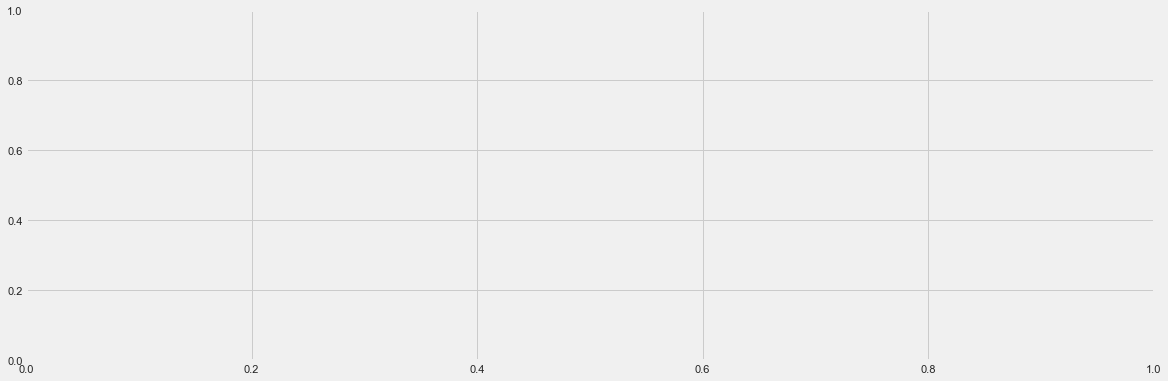

In [7]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots(figsize = (18, 6))
ax.plot(range(2,20), silhouette)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.set_xticks(np.arange(2,21,3.0))
silhouette_fig.suptitle("identifying Optimal Cluster Number ", weight = "bold", size = 18)

In [8]:
silhouette_diff = []
for i in range(1,len(silhouette)):
  improvement = 1 - ((1 - silhouette[i]) / (1 - silhouette[i - 1]))
  silhouette_diff.append(improvement)
  print("For n_cluster = {}, percent improvement = {}".format(i + 2, improvement))


ValueError: x and y must have same first dimension, but have shapes (17,) and (0,)

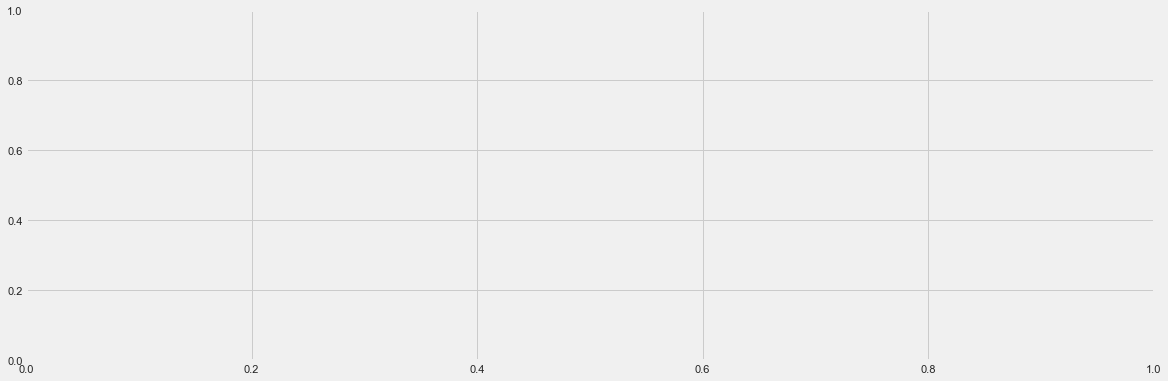

In [9]:
plt.style.use('fivethirtyeight')
silhouette_imp_fig, ax = plt.subplots(figsize = (18,6))
ax.plot(range(2,19), silhouette_diff)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("% Silhouette improvement")
ax.set_xticks(np.arange(2,19,2.0))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

silhouette_imp_fig.suptitle("identifying Optimal Cluster Number ", weight = "bold", size = 18)

### **Insights + running the clustering algorithm**

We can see a sharp imporvement in silhouette scores when the number of clusters goes to four, and the sum of squares is also reasonably low with 4. Four also gives us a nice number to work with when making sense of the clusters. So let's choose 4 and perform the clustering. 

In [10]:
from sklearn.cluster import KMeans

# Set "optimal" Clustering Parameters
num_clust = 4
init_algo = 'k-means++'

# Create Clustering Model using KMeans
kmeans = KMeans(n_clusters = num_clust,         
               init = init_algo,
               n_init = 20)                 

# Fit the Clustering Model on the Data
kmeans.fit(predictors)

NameError: name 'predictors' is not defined

In [11]:
print("Features", "\tHomePossession", "\tHomeTouches", "\tHomePasses", "\tHomeTackles", "\tHomeClearances", "\tHomeOffsides", "\tHomeShots", "HomeShotsOnTarget")
print()

for i, center in enumerate(kmeans.cluster_centers_):
    print("Cluster", i, end=":\t")
    for coord in center:
        print(round(coord, 2), end="\t")
    print()
print()

# Print the Within Cluster Sum of Squares
print("Within Cluster Sum of Squares :", kmeans.inertia_)
print()

# Predict the Cluster Labels
labels = kmeans.predict(predictors)

# Append Labels to the Data
clustering_data_labeled = predictors.copy()
clustering_data_labeled["Cluster"] = pd.Categorical(labels)

# Summary of the Cluster Labels

sb.catplot(y = "Cluster", data = clustering_data_labeled, kind = "count")

Features 	HomePossession 	HomeTouches 	HomePasses 	HomeTackles 	HomeClearances 	HomeOffsides 	HomeShots HomeShotsOnTarget



AttributeError: 'KMeans' object has no attribute 'cluster_centers_'

# Making sense of the clusters

In [12]:
sb.pairplot(clustering_data_labeled, vars = predictors.columns.values, hue = "Cluster")

NameError: name 'clustering_data_labeled' is not defined

In [13]:
clustering_data_labeled["HomeShotsOnTarget"] = final_data["HomeShotsOnTarget"]
clustering_data_labeled["HomeGoals"] = final_data["HomeGoals"]
clustering_data_labeled["HomeShots"] = final_data["HomeShots"]
cluster_data = pd.DataFrame(clustering_data_labeled.groupby(by = "Cluster").mean())
final_data["Cluster"] = labels

NameError: name 'final_data' is not defined

NameError: name 'clustering_data_labeled' is not defined

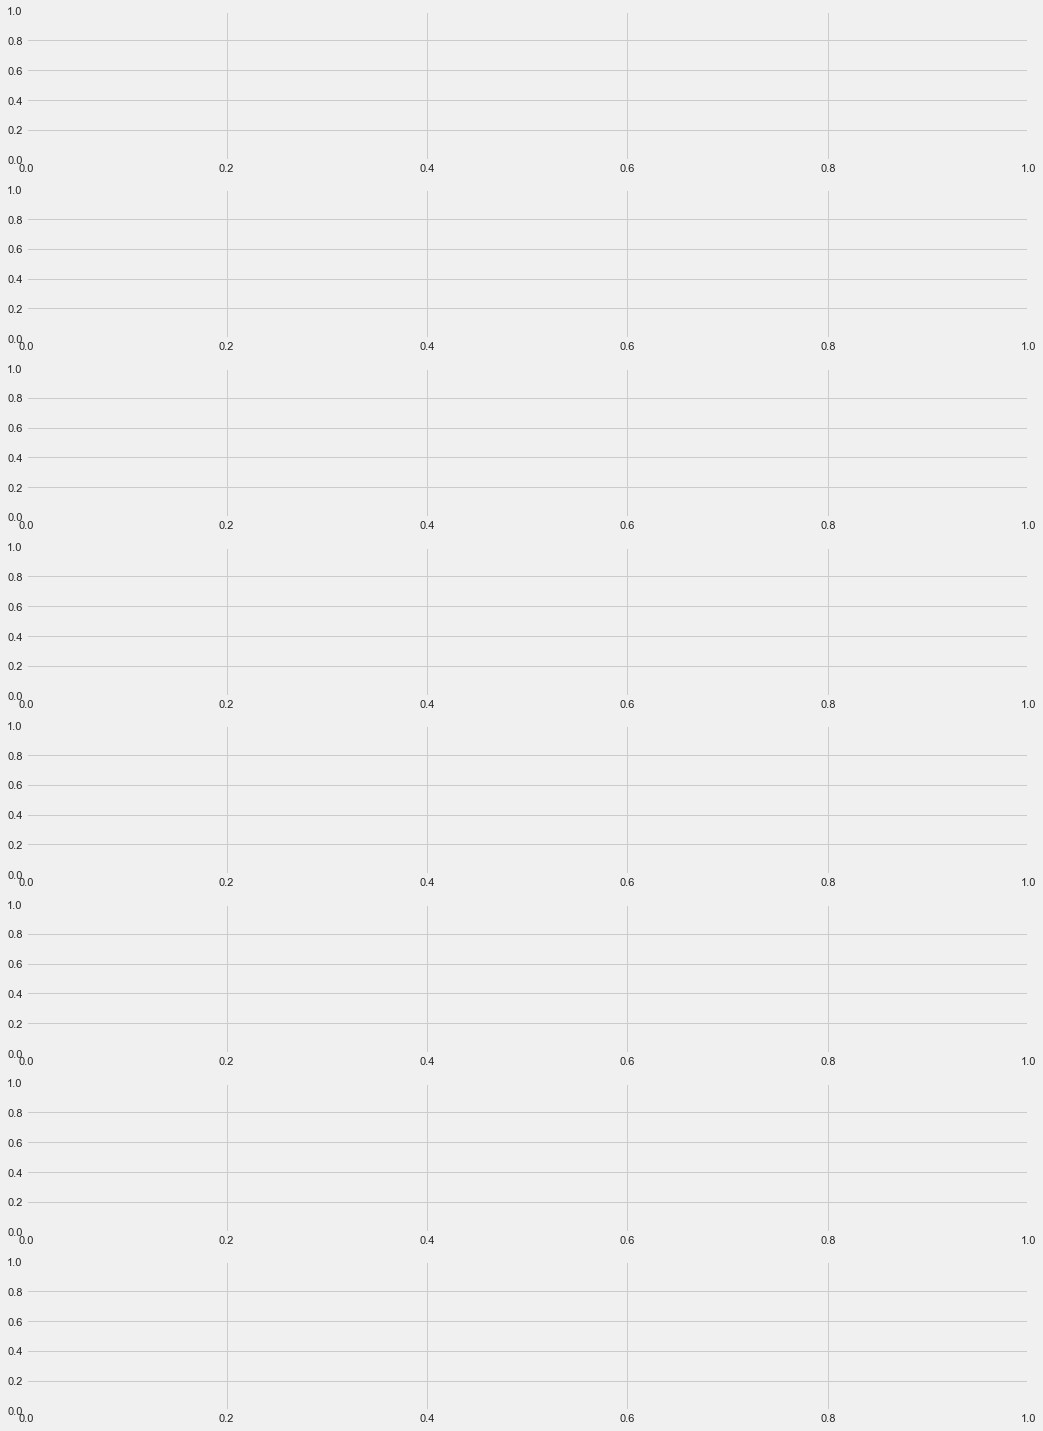

In [14]:
f, axes = plt.subplots(8, 1, figsize=(16,24))
sb.boxplot(x = 'HomePossession', y = 'Cluster', data = clustering_data_labeled, ax = axes[0])
sb.boxplot(x = 'HomeTouches', y = 'Cluster', data = clustering_data_labeled, ax = axes[1])
sb.boxplot(x = 'HomePasses', y = 'Cluster', data = clustering_data_labeled, ax = axes[2])
sb.boxplot(x = 'HomeTackles', y = 'Cluster', data = clustering_data_labeled, ax = axes[3])
sb.boxplot(x = 'HomeClearances', y = 'Cluster', data = clustering_data_labeled, ax = axes[4])
sb.boxplot(x = 'HomeOffsides', y = 'Cluster', data = clustering_data_labeled, ax = axes[5])
sb.boxplot(x = 'HomeGoals', y = 'Cluster', data = clustering_data_labeled, ax = axes[6])


Hmm... it seems that our algorithm decided to cluster the data mostly based on **passes, possession, and touches**. Cluster 2 (yellow color) seems to have the highest possession, highest touches and highest passes. Cluster 0 (blue) seems to have the next highest for all 3 of these metrics, followed by Cluster 1 (red), and finally, Cluster 3 (green).

Are some of these playstyles more successful than others? Lets look at the average number of goals each cluster has scored per game 

In [15]:
for i in range(0,num_clust):
    print(f"Cluster {i} has scored " + str(clustering_data_labeled.loc[clustering_data_labeled["Cluster"] == i]["HomeGoals"].mean()) + " per game")


NameError: name 'clustering_data_labeled' is not defined

### **Insights**

Clearly, Cluster 2, with the highest possession, passing and touches, scored by far the most goals, with nearly 2 per game. 
This pattern follows for the rest - the lower these 3 variables are, the lower the number of goals scored per game.  

From this analysis, we can clearly see that **teams should choose to maximise possession, passing and touches in order to likely score more goals** throughout the game.

However, is this always the case? There have clearly been many famous wins where the winning team had much lower possession. We know that some teams, like Mourinho's Chelsea in 2013/14, willingly chose to give up possession to the opposition as a playstyle. This resulted in their famous 2-0 win over Liverpool which lost Liverpool the title that season.

So, should teams ever have a reason to NOT maximise these variables? Let's do some feature engineering to find out.

# Model 4: Feature engineering with simple linear regression

### Finding the feature

The goal of this feature engineering is to **find a 'helpful' variable that actually *decreases* with possession, passing and touches**

From my domain knowledge, I know that teams that play with more passes, possession and touches may end up taking poorer quality shots (meaning, the shots have a lower chance of being a goal), whereas teams with lower possession have greater counter-attack opportunities, and thus their shots have higher chance of being a goal.

Here are some nice counterattack goals: https://youtu.be/ZQX_fOxvd28

One can see that these shots have much higher chance of goal due to the opposition defence needing to chase back. I shall this "chance of goal per shot" variable **"Shot Quality"**. 

We can calculate this by using **bi-variate linear regression** to predict the regular number of goals we expect a team to score given their shots on target, and we calculate the difference in shots on target.

In other words, 

<code>shot quality = (goals actually scored) - (goals predicted by bi-var linreg based on shots taken)</code>
<br>

Let's calculate this!



#### **Predictor: ShotsOnTarget**
#### **Response: Goals Scored**


In [17]:

from sklearn.linear_model import LinearRegression

clusters = [final_data.loc[final_data["Cluster"] == x] for x in range(0,4)]

linreg = LinearRegression()         # create the linear regression object
linreg.fit(pd.DataFrame(final_data["HomeShotsOnTarget"]), pd.DataFrame(final_data["HomeGoals"]))       # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', float(linreg.intercept_))
print('Coefficients of Regression \t: a = ', float(linreg.coef_))
print()
coef = float(linreg.coef_)
intercept = float(linreg.intercept_)

def model(x):
    return coef * x + intercept

final_data["ShotQuality"] = final_data["HomeGoals"] - final_data["HomeShotsOnTarget"].apply(model)
    # Print the Coefficients against Predictors


NameError: name 'final_data' is not defined

In [18]:
for i in range(0,num_clust):
    print(f"Shot quality of cluster {i} (times 100) :\t", final_data.loc[final_data["Cluster"] == i]["ShotQuality"].mean()*100)

NameError: name 'final_data' is not defined

### **Insights**

It seems that we have reached the opposite to our hypothesis above - as cluster 2 has a much higher shot quality (28.9) than the rest (next highest is cluster 0 with 6.78), it seems that teams who play with higher possession actually take much better shots as well. 

We are surprised to see this, but it could just be the case that these teams have superior players overall, who are just capable of taking much better shots than the rest of the league.

**Thus, our recommendation from our clustering algorithm remains - one should aim to maximise passing, possession, and touches as far as possible to win football matches**

# Conclusion

Given the data that we have is very limited, we believe that there is scope for much more analysis. In particular, we would be interested to know *how* a team can maximise the above three key metrics. 

We hope the above analysis was interesting. Thank you!
